Importação das bibliotecas e verficação de GPU

In [2]:
!curl -O https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
!curl -O https://thor.robots.ox.ac.uk/datasets/pets/annotations.tar.gz
!
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  11.0M      0  0:01:08  0:01:08 --:--:-- 12.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0   382k      0  0:00:48  0:00:48 --:--:--  349k


In [1]:
import os
import keras
import numpy as np
import tensorflow as tf
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io

2024-03-18 23:22:01.805728: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-18 23:22:01.805752: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-18 23:22:01.806386: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-18 23:22:01.810159: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (128, 128)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


In [28]:
def resize(img):
    return tf.image.resize(img, (128, 128), method='nearest')

def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       img = tf.image.flip_left_right(img)
   return img

In [29]:
def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Returns a TF Dataset."""

    def load_img_masks(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.resize(input_img, img_size)
        input_img = tf_image.convert_image_dtype(input_img, "float32")

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.resize(target_img, img_size, method="nearest")
        target_img = tf_image.convert_image_dtype(target_img, "uint8")

        # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
        target_img -= 1
        return input_img, target_img

    # For faster debugging, limit the size of data
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)

In [30]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate dataset for each split
# Limit input files in `max_dataset_len` for faster epoch training time.
# Remove the `max_dataset_len` arg when running with full dataset.
train_dataset = get_dataset(
    batch_size,
    img_size,
    train_input_img_paths,
    train_target_img_paths,
    max_dataset_len=1000,
)
valid_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)

In [31]:
print(train_dataset)
print(valid_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.uint8, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.uint8, name=None))>


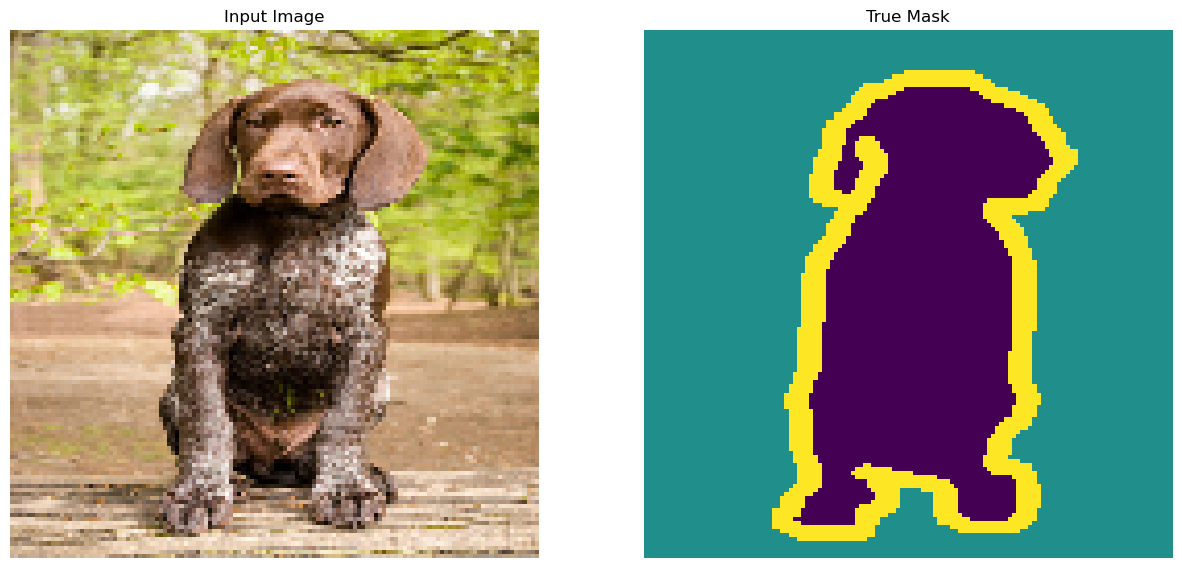

In [47]:
import matplotlib.pyplot as plt

def display_img(display_list):
 plt.figure(figsize=(15, 15))
 title = ["Input Image", "True Mask", "Predicted Mask"]
 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()
 
sample_batch = next(iter(train_dataset))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display_img([sample_image, sample_mask])

In [33]:
from tensorflow.keras import layers

def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

    return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)

   x = double_conv_block(x, n_filters)
   return x

# BackBone of the network

In [34]:
def build_unet_model():
   inputs = layers.Input(shape=(128,128,3))
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)
   # outputs
   outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)
   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model

In [35]:
unet_model = build_unet_model()
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 128, 128, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_39 (Conv2D)             (None, 128, 128, 64  36928       ['conv2d_38[0][0]']              
                                )                                                             

In [36]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(), loss="sparse_categorical_crossentropy", metrics="accuracy")
callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)
]

epochs = 50

model_history = unet_model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=2,
)

Epoch 1/50


2024-03-18 23:54:16.173239: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-Net/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-18 23:54:16.477050: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-03-18 23:54:17.000645: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-18 23:54:17.180671: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were availabl

32/32 - 45s - loss: 5.8850 - accuracy: 0.4880 - val_loss: 0.9677 - val_accuracy: 0.5674 - 45s/epoch - 1s/step
Epoch 2/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 18s - loss: 0.9120 - accuracy: 0.5765 - val_loss: 0.8714 - val_accuracy: 0.5838 - 18s/epoch - 566ms/step
Epoch 3/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 18s - loss: 0.8595 - accuracy: 0.5846 - val_loss: 0.8402 - val_accuracy: 0.5921 - 18s/epoch - 563ms/step
Epoch 4/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 18s - loss: 0.8123 - accuracy: 0.6295 - val_loss: 0.7767 - val_accuracy: 0.6911 - 18s/epoch - 567ms/step
Epoch 5/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 18s - loss: 0.7694 - accuracy: 0.6958 - val_loss: 0.7681 - val_accuracy: 0.6926 - 18s/epoch - 571ms/step
Epoch 6/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 20s - loss: 0.7628 - accuracy: 0.6987 - val_loss: 0.7357 - val_accuracy: 0.7028 - 20s/epoch - 622ms/step
Epoch 7/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 19s - loss: 0.7323 - accuracy: 0.7101 - val_loss: 0.7082 - val_accuracy: 0.7192 - 19s/epoch - 585ms/step
Epoch 8/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 17s - loss: 0.6990 - accuracy: 0.7235 - val_loss: 0.7695 - val_accuracy: 0.6789 - 17s/epoch - 539ms/step
Epoch 9/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 18s - loss: 0.6916 - accuracy: 0.7253 - val_loss: 0.6869 - val_accuracy: 0.7261 - 18s/epoch - 576ms/step
Epoch 10/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 18s - loss: 0.6870 - accuracy: 0.7279 - val_loss: 0.6830 - val_accuracy: 0.7293 - 18s/epoch - 575ms/step
Epoch 11/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 19s - loss: 0.6649 - accuracy: 0.7364 - val_loss: 0.6426 - val_accuracy: 0.7456 - 19s/epoch - 592ms/step
Epoch 12/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 17s - loss: 0.6528 - accuracy: 0.7415 - val_loss: 0.6637 - val_accuracy: 0.7408 - 17s/epoch - 529ms/step
Epoch 13/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 17s - loss: 0.6285 - accuracy: 0.7518 - val_loss: 0.6445 - val_accuracy: 0.7459 - 17s/epoch - 518ms/step
Epoch 14/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 18s - loss: 0.6128 - accuracy: 0.7576 - val_loss: 0.6272 - val_accuracy: 0.7508 - 18s/epoch - 566ms/step
Epoch 15/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 18s - loss: 0.6237 - accuracy: 0.7528 - val_loss: 0.6155 - val_accuracy: 0.7648 - 18s/epoch - 567ms/step
Epoch 16/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 18s - loss: 0.5827 - accuracy: 0.7682 - val_loss: 0.5796 - val_accuracy: 0.7704 - 18s/epoch - 558ms/step
Epoch 17/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 18s - loss: 0.5668 - accuracy: 0.7754 - val_loss: 0.5718 - val_accuracy: 0.7727 - 18s/epoch - 567ms/step
Epoch 18/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 17s - loss: 0.5609 - accuracy: 0.7780 - val_loss: 0.5774 - val_accuracy: 0.7746 - 17s/epoch - 538ms/step
Epoch 19/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 18s - loss: 0.5628 - accuracy: 0.7779 - val_loss: 0.5519 - val_accuracy: 0.7833 - 18s/epoch - 569ms/step
Epoch 20/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 17s - loss: 0.5313 - accuracy: 0.7908 - val_loss: 0.5880 - val_accuracy: 0.7638 - 17s/epoch - 524ms/step
Epoch 21/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 17s - loss: 0.5791 - accuracy: 0.7705 - val_loss: 0.5638 - val_accuracy: 0.7771 - 17s/epoch - 535ms/step
Epoch 22/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 19s - loss: 0.5489 - accuracy: 0.7846 - val_loss: 0.5378 - val_accuracy: 0.7896 - 19s/epoch - 579ms/step
Epoch 23/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 17s - loss: 0.5140 - accuracy: 0.7998 - val_loss: 0.5424 - val_accuracy: 0.7906 - 17s/epoch - 534ms/step
Epoch 24/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 18s - loss: 0.5074 - accuracy: 0.8020 - val_loss: 0.5356 - val_accuracy: 0.7921 - 18s/epoch - 571ms/step
Epoch 25/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 18s - loss: 0.4894 - accuracy: 0.8084 - val_loss: 0.5258 - val_accuracy: 0.7970 - 18s/epoch - 575ms/step
Epoch 26/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 19s - loss: 0.4858 - accuracy: 0.8108 - val_loss: 0.5164 - val_accuracy: 0.7987 - 19s/epoch - 578ms/step
Epoch 27/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 17s - loss: 0.4686 - accuracy: 0.8184 - val_loss: 0.5405 - val_accuracy: 0.7919 - 17s/epoch - 536ms/step
Epoch 28/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 17s - loss: 0.4856 - accuracy: 0.8106 - val_loss: 0.5332 - val_accuracy: 0.7944 - 17s/epoch - 535ms/step
Epoch 29/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 18s - loss: 0.4779 - accuracy: 0.8148 - val_loss: 0.5095 - val_accuracy: 0.8017 - 18s/epoch - 570ms/step
Epoch 30/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 17s - loss: 0.4647 - accuracy: 0.8199 - val_loss: 0.5190 - val_accuracy: 0.7990 - 17s/epoch - 531ms/step
Epoch 31/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 18s - loss: 0.4418 - accuracy: 0.8299 - val_loss: 0.4949 - val_accuracy: 0.8109 - 18s/epoch - 577ms/step
Epoch 32/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 18s - loss: 0.4217 - accuracy: 0.8368 - val_loss: 0.4785 - val_accuracy: 0.8179 - 18s/epoch - 577ms/step
Epoch 33/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 18s - loss: 0.4038 - accuracy: 0.8442 - val_loss: 0.4698 - val_accuracy: 0.8215 - 18s/epoch - 574ms/step
Epoch 34/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 17s - loss: 0.4376 - accuracy: 0.8342 - val_loss: 0.4732 - val_accuracy: 0.8174 - 17s/epoch - 524ms/step
Epoch 35/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 17s - loss: 0.4116 - accuracy: 0.8415 - val_loss: 0.4903 - val_accuracy: 0.8122 - 17s/epoch - 527ms/step
Epoch 36/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 17s - loss: 0.4080 - accuracy: 0.8426 - val_loss: 0.5085 - val_accuracy: 0.8102 - 17s/epoch - 531ms/step
Epoch 37/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 17s - loss: 0.3912 - accuracy: 0.8502 - val_loss: 0.5453 - val_accuracy: 0.8031 - 17s/epoch - 533ms/step
Epoch 38/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 17s - loss: 0.4112 - accuracy: 0.8442 - val_loss: 0.5369 - val_accuracy: 0.8004 - 17s/epoch - 533ms/step
Epoch 39/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 17s - loss: 0.3955 - accuracy: 0.8474 - val_loss: 0.5321 - val_accuracy: 0.8080 - 17s/epoch - 530ms/step
Epoch 40/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 17s - loss: 0.3653 - accuracy: 0.8594 - val_loss: 0.5419 - val_accuracy: 0.8047 - 17s/epoch - 533ms/step
Epoch 41/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 17s - loss: 0.3648 - accuracy: 0.8595 - val_loss: 0.5322 - val_accuracy: 0.8095 - 17s/epoch - 542ms/step
Epoch 42/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 17s - loss: 0.3796 - accuracy: 0.8536 - val_loss: 0.5273 - val_accuracy: 0.8121 - 17s/epoch - 537ms/step
Epoch 43/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 17s - loss: 0.3566 - accuracy: 0.8635 - val_loss: 0.4965 - val_accuracy: 0.8139 - 17s/epoch - 536ms/step
Epoch 44/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 17s - loss: 0.3508 - accuracy: 0.8647 - val_loss: 0.4746 - val_accuracy: 0.8271 - 17s/epoch - 537ms/step
Epoch 45/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 17s - loss: 0.3448 - accuracy: 0.8670 - val_loss: 0.4905 - val_accuracy: 0.8262 - 17s/epoch - 532ms/step
Epoch 46/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 17s - loss: 0.3314 - accuracy: 0.8725 - val_loss: 0.5078 - val_accuracy: 0.8239 - 17s/epoch - 538ms/step
Epoch 47/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 17s - loss: 0.3136 - accuracy: 0.8781 - val_loss: 0.5081 - val_accuracy: 0.8287 - 17s/epoch - 535ms/step
Epoch 48/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 17s - loss: 0.3089 - accuracy: 0.8795 - val_loss: 0.4901 - val_accuracy: 0.8333 - 17s/epoch - 538ms/step
Epoch 49/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 17s - loss: 0.3141 - accuracy: 0.8783 - val_loss: 0.5226 - val_accuracy: 0.8114 - 17s/epoch - 529ms/step
Epoch 50/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 17s - loss: 0.3167 - accuracy: 0.8771 - val_loss: 0.5470 - val_accuracy: 0.8185 - 17s/epoch - 531ms/step


32/32 [==============================] - 3s 102ms/step


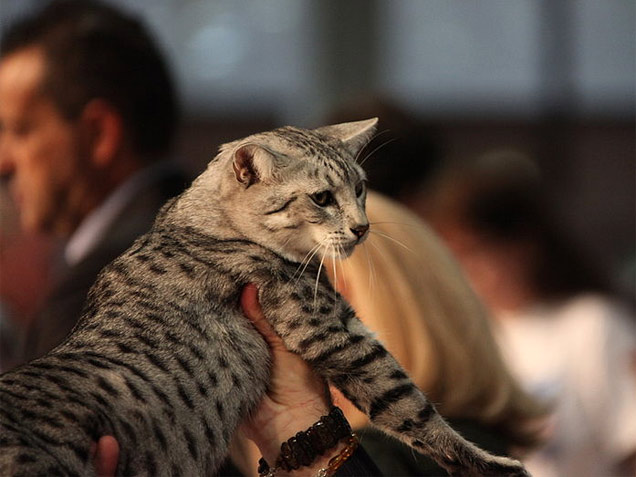

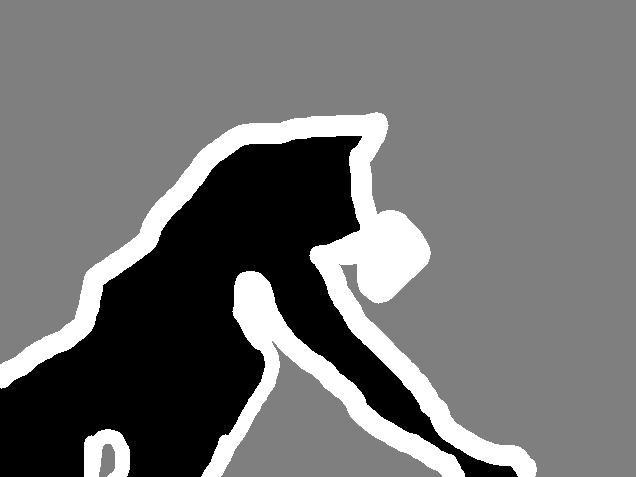

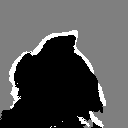

In [52]:
from IPython.display import Image, display
from keras.utils import load_img
from PIL import ImageOps

val_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)
val_preds = unet_model.predict(val_dataset)

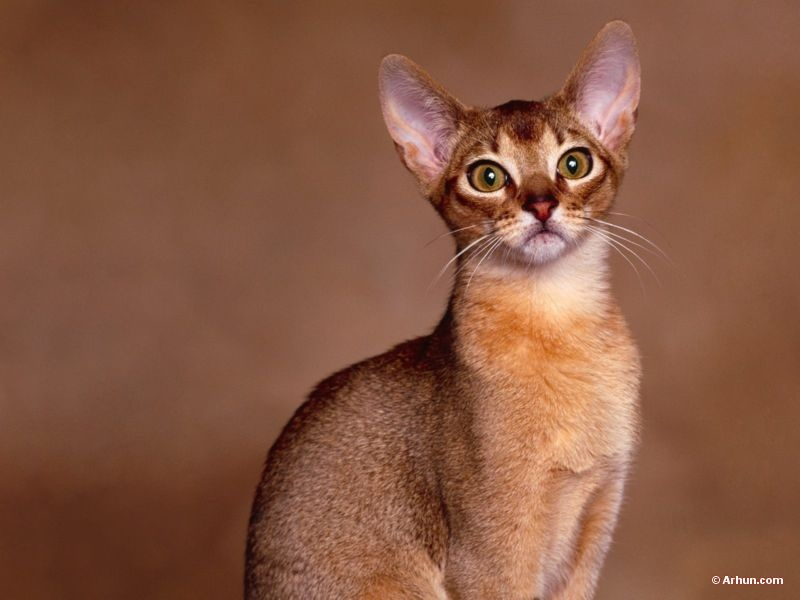

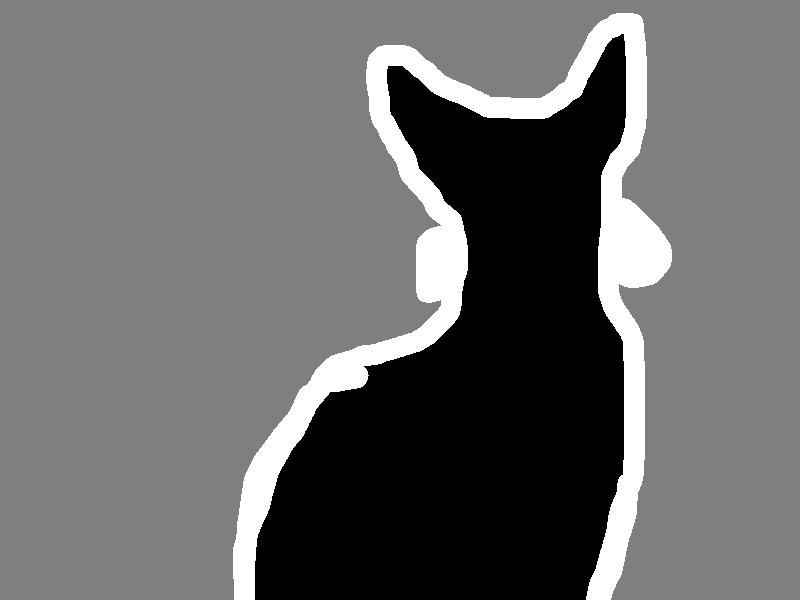

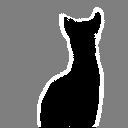

In [54]:
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    display(img)


i = 1

# Display input image
display(Image(filename=val_input_img_paths[i]))

# # Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# # Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.